<a href="https://colab.research.google.com/github/algo74/MLCourse/blob/master/HW1/hw1_problem2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW1. Problem 2. 

- Load the training and test data using Keras, no validation set needed.
- Train 10 classifiers that perform binary classification: *Is the input image the digit i or is it a digit different from i?* Each of the ten classifiers has an input layer consisting of 28 x 28 input neurons and an output layer consisting of a single output neuron.
- Implement mini-batch stochastic gradient descent using only numpy, that is, you are not allowed to use TensorFlow/Keras for SGD.
- Use *`argmax`* to determine the classifier with the strongest output and declare the corresponding digit as output.
- Use logistic regression with **binary cross entropy loss.**



##Comments
* The majority of the code is the same as for problem 1. Only functions ``Loss`` and `gradLoss` changed.
* Code for loading and preparing of the data is reused from `mnist_digits_classification_dense_layers.ipynb`
* Some other code is reused from `linear_regression_gradient_descent.ipynb`

## Loading the image data

In [0]:
import numpy as np
from keras.datasets import mnist
import math

(train_images_original, train_labels_original), (test_images_original, test_labels_original) = mnist.load_data()

# shape parameters
m = 60000
m_test = 10000

## Preparing the image data

In [0]:
train_images = train_images_original.reshape((m, 28 * 28))
train_images = train_images.astype('float32') / 255

test_images = test_images_original.reshape((m_test, 28 * 28))
test_images = test_images.astype('float32') / 255

## Preparing the labels

We need to categorically encode the labels.

In [0]:
from keras.utils import to_categorical

train_labels = to_categorical(train_labels_original)
test_labels = to_categorical(test_labels_original)

## Adding biases


In [0]:
X_b = np.c_[np.ones((m,1)), train_images]
tstX_b = np.c_[np.ones((m_test,1)), test_images]

## Display prepared data

In [58]:
print(X_b[0:2])
# print(X_b[3])
print(X_b.shape)
print(X_b.shape[1])

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
(60000, 785)
785


In [0]:
# help(np.random.standard_normal)

## Defining different helper functions unrelated to ML

In [0]:
from IPython.display import HTML, display
import time

# https://stackoverflow.com/questions/46939393/how-do-i-use-updatable-displays-on-colab
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 80%'
        >
            {value}
        </progress>
        <p>{value} of {max} complete</p>
    """.format(value=value, max=max))

## Defining model

In [0]:
initial_weights = np.random.randn(X_b.shape[1],10)
weights=initial_weights
learning_rate = 0.1
batch_size = 30

In [0]:

# https://gist.github.com/jovianlin/805189d4b19332f8b8a79bbd07e3f598#gistcomment-2756475
def sigmoid(x, derivative=False):
  sigm = 1. / (1. + np.exp(-x))
  if derivative:
      return sigm * (1. - sigm)
  return sigm
  
def calcAccuracy(real, predicted):
  r = real.argmax(1)
  p = predicted.argmax(1)
  return (r == p).sum()/r.shape
   
def Acc(X, y, W): return calcAccuracy(y, X.dot(W))

# only for debug to figure out which activations are outside (0,1) 
def debugA(X, y, W, a, z):
  m = X.shape[0]
  problem_indexes = [i for i in range(m) if (a[i] >= 1).any() or (a[i] <= 0).any()]
  print(len(problem_indexes))
  for k in problem_indexes:
    print('a: ', a[k])
    print('z: ', z[k])
    print('y: ', y[k])
    #print('X: ', X[k])
  
# Binary Cross-Entropy loss
# only correct if y contains only zeros and ones
def Loss(X, y, W): 
  m = X.shape[0]
  z = X.dot(W)  # matrix(m x 10)
  a = sigmoid(z)
  
  # trouble checking
  too_low = (a[y==1] <= 0).sum()
  too_big = (a[y==0] >= 1).sum()
  if too_low != 0 : 
    print(too_low, 'a\'s is too low')
    debugA(X, y, W, a, z)
  if too_big != 0: 
    print(too_big, 'a\'s is too high')
    debugA(X, y, W, a, z)
  #check that all y's are either zeros or ones
  not_hot_nor_cold = (y[y!=1] != 0).sum()
  if not_hot_nor_cold != 0:
    print(not_hot_nor_cold, 'values are neither ones nor zeros')
    
  # The following is only correct if y is either 0 or 1
  # We have to do this so that we never calculate log(0)
  # but keep calculations in matrix forms
  pre_log = a*y + (1-a)*(1-y)
  return -(np.log(pre_log)).sum(0)/m # vector(10)

def gradLoss(m, X, y, W):
  z = X.dot(W)
  a = sigmoid(z) # matrix(m x 10)
  return 1/m * X.T.dot( ((1-y)/(1-a) - y/a) * sigmoid(z, True) )

# returns new weights
def one_epoch(X, W, y, batch_size):
  m=X.shape[0]
  shuffled_indices = np.random.permutation(m)
  Xs = X[shuffled_indices]
  ys = y[shuffled_indices]
  Wi=W
  for i in range(0, m, batch_size):
    Xi = Xs[i:i+batch_size]
    yi = ys[i:i+batch_size]
    gradient = gradLoss(batch_size, Xi, yi, Wi)
    Wi = Wi - learning_rate * gradient
  return Wi


def init_model():
  global weights
  global loss_values
  global tst_loss_values
  global tr_acc
  global tst_acc
  weights = initial_weights
  loss_values=[]
  tst_loss_values=[]
  tr_acc=[]
  tst_acc=[]

def train(epoches):
  global weights
  pr_bar = display(progress(0, epoches), display_id=True)
  for epoch in range(epoches):
    weights = one_epoch(X_b, weights, train_labels, batch_size)
    loss_values.append(Loss(X_b, train_labels, weights))
    tst_loss_values.append(Loss(tstX_b, test_labels, weights))
    tr_acc.append(Acc(X_b, train_labels, weights))
    tst_acc.append(Acc(tstX_b, test_labels, weights))
    pr_bar.update(progress(epoch+1, epoches))
  

## The training step

In [85]:
epochs = 50
init_model()
train(epochs)
# print(loss_values)

## Display the training/test loss/accuracy

In [0]:
epochs_range = range(1, epochs + 1)

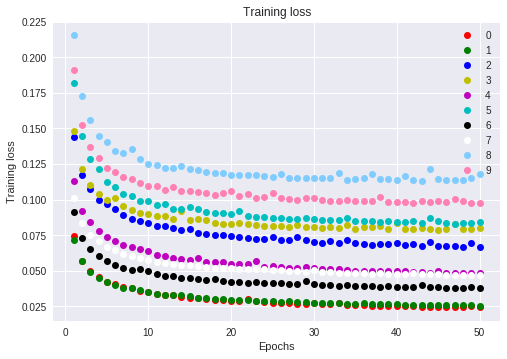

In [87]:
import matplotlib.pyplot as plt
from cycler import cycler

plt.rc('axes', prop_cycle=(cycler('color', ['r','g','b','y','m','c','k','w',(.5, .8, 1),(1, .5, .7)])))

[p0, p1, p2, p3, p4, p5, p6, p7, p8, p9]=plt.plot(epochs_range, loss_values, 'o')

plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.legend([p0, p1, p2, p3, p4, p5, p6, p7, p8, p9], [0,1,2,3,4,5,6,7,8,9])

plt.show()

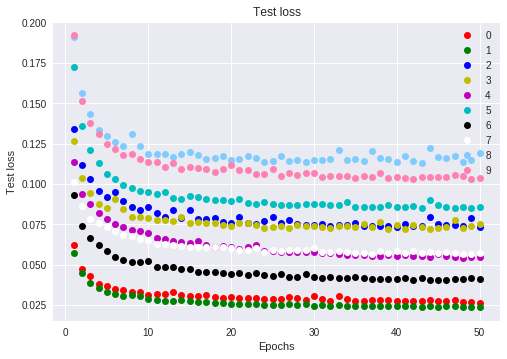

In [88]:
[p0, p1, p2, p3, p4, p5, p6, p7, p8, p9]=plt.plot(epochs_range, tst_loss_values, 'o')

plt.title('Test loss')
plt.xlabel('Epochs')
plt.ylabel('Test loss')
plt.legend([p0, p1, p2, p3, p4, p5, p6, p7, p8, p9], [0,1,2,3,4,5,6,7,8,9])

plt.show()

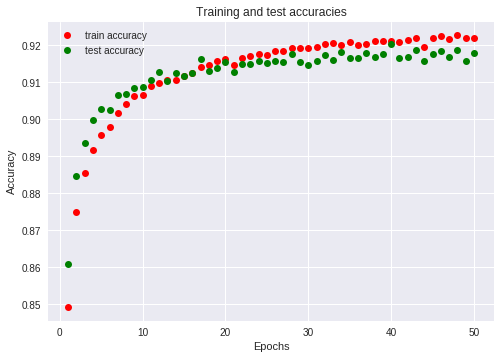

In [89]:
plt.plot(epochs_range, tr_acc, 'ro', label="train accuracy")
plt.plot(epochs_range, tst_acc, 'go', label="test accuracy")


plt.title('Training and test accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# print(tr_acc)
# print(tst_acc)

## Exploring results

In [90]:
predicted_labels = np.argmax(tstX_b.dot(weights), axis=1) 
predicted_labels = predicted_labels.astype('uint8')
wrong_indices = [i for i in range(10000) if predicted_labels[i] != test_labels_original[i]]
good_indices = [i for i in range(10000) if predicted_labels[i] == test_labels_original[i]]
1.0 - len(wrong_indices) / 10000.0

0.918

6 is classified as 5


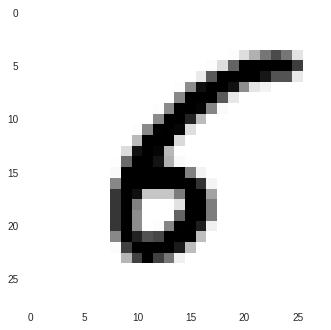

In [91]:
# This show the ith misclassified digit. 
i = 9
wrong_index = wrong_indices[i]  
print(test_labels_original[wrong_index], 'is classified as', predicted_labels[wrong_index])
plt.imshow(test_images_original[wrong_index])
plt.grid(None)
plt.show()

3 is classified as 3


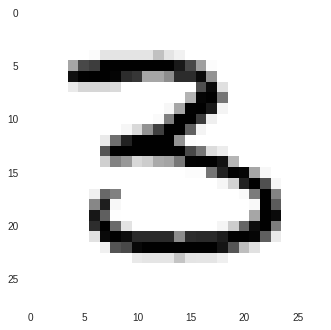

In [93]:
# This show the ith correctly classified digit. 
i = 999
index = good_indices[i]  
print(test_labels_original[index], 'is classified as', predicted_labels[index])
plt.imshow(test_images_original[index])
plt.grid(None)
plt.show()